In [1]:
!pip install keras_cv

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras_cv
from datetime import datetime
import random

Using TensorFlow backend


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DEPICTION = "wing"
species_list = ['AE', 'AL', "JA", 'KO']

# on colab
DIR_PATH = "/content/drive/MyDrive/PhD/WingDatabase/DepictionDataset/{}".format(DEPICTION)
SAVE_DIR = "/content/drive/MyDrive/PhD/WingComparisonStudy/models_demand"
# on own device
#DIR_PATH = "/Users/kristophernolte/Documents/phd_comparison/Datasets/processed/{}".format(DEPICTION)
#SAVE_DIR = "/Users/kristophernolte/Documents/phd_comparison/Datasets/processed/{}/models".format(DEPICTION)

IMG_SIZE = 300
BATCH_SIZE = 16
LEARNING_RATE_TRANSFER = 5e-4
LEARNING_RATE_TUNING = 1e-5
MAX_EPOCHS_TRANSFER = 24
MAX_EPOCHS_TUNING = 24
EARLY_STOP_PATIENCE = 12
STEPS_PER_EPOCH = 81
COSINE_DECAY_STEPS = STEPS_PER_EPOCH * MAX_EPOCHS_TUNING
DROPOUT = 0.5
SEED = 19

AUG_LAYER = 3
AUG_MAGNITUDE = .05
AUG_ROTATTION = .05
AUG_TRANSLATION = .05
AUG_SHARPNESS = .25
AUG_COLORDEGEN = .25
AUG_NOISE = .1

In [5]:
def create_dict(data_split):
    #get a list of image paths defined by the target list
    image_path_dict = {}

    for species in species_list:
        path = DIR_PATH + "/{}/{}/*.png".format(data_split, species)
        image_path_dict[species] = tf.data.Dataset.list_files(path,  shuffle=True, seed=SEED)

    return image_path_dict

def combine_dict(dataset_dict, N, run=-1):
  #combine all target_dicts together
  for i,key in enumerate(dataset_dict.keys()):
    # For Testing and Validation
    if N == -1:
      if i == 0:
          image_path_ds = dataset_dict[key]
      else:
          image_path_ds = image_path_ds.concatenate(dataset_dict[key])

    # For Training
    else:
      if i == 0:
          image_path_ds = dataset_dict[key].shuffle(seed = run, buffer_size=dataset_dict[key].cardinality()).take(N)
      else:
          image_path_ds = image_path_ds.concatenate(dataset_dict[key].shuffle(seed = run, buffer_size=dataset_dict[key].cardinality()).take(N))

  return image_path_ds

#create dicts with species as key and tf.ShuffleDataset containing paths as values
train_path_dict = create_dict("train")
val_path_dict = create_dict("val")
test_path_dict = create_dict("test")

#combine dicts to Tensorflow dataset
valDS_filelist = combine_dict(val_path_dict, N=-1)
testDS_filelist = combine_dict(test_path_dict, N=-1)

In [6]:
def getLabel_onehot(file_path):
    # Convert the path to a list of path components
    speciesName = tf.strings.split(file_path, os.path.sep)[-2]
    # get one_hot vector boolean
    species_one_hot = speciesName == species_list
    # cast vector type to integer
    species_one_hot = tf.cast(species_one_hot, dtype=tf.int8, name=None)
    return species_one_hot

def getImage(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img

def process_path(file_path):
    species_label = getLabel_onehot(file_path)
    img = getImage(file_path)

    return img, species_label

valDS_raw = valDS_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
testDS_raw = testDS_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

valDS = valDS_raw.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
testDS = testDS_raw.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [7]:
def build_model():
    BASE_MODEL = tf.keras.applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3), include_preprocessing=True)
    BASE_MODEL.trainable = False

    #Fully Connected Segment
    flatten_layer = tf.keras.layers.GlobalAveragePooling2D()(BASE_MODEL.output)
    regu_layer = tf.keras.layers.Dropout(0.5)(flatten_layer)
    output_layer = tf.keras.layers.Dense(4, activation = "softmax")(regu_layer)

    #Built Model
    model = tf.keras.Model(inputs=BASE_MODEL.inputs, outputs=output_layer)

    return model

def transfer_model(model_name, trainDS_subset_batched):
    model = build_model()

    LOSS = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    OPTIMIZER_TRANSFER = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE_TRANSFER)
    EARLY_STOP = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = EARLY_STOP_PATIENCE, mode='auto', restore_best_weights=False)

    model.compile(optimizer=OPTIMIZER_TRANSFER, loss=LOSS, metrics=["accuracy"])

    history = model.fit(trainDS_subset_batched, epochs=MAX_EPOCHS_TRANSFER, validation_data=valDS, callbacks=[EARLY_STOP])
    loss, accuracy = model.evaluate(testDS)

    return loss, accuracy, model


def finetune_model(model, trainDS_subset_batched):
    fine_tune_at = int(len(model.layers)*0.5)
    for layer in model.layers[fine_tune_at:]:
      if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

    OPTIMIZER_TUNING = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE_TUNING)
    EARLY_STOP = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = EARLY_STOP_PATIENCE, mode='auto', restore_best_weights=False)
    LOSS = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(optimizer=OPTIMIZER_TUNING, loss=LOSS, metrics=["accuracy"])
    history = model.fit(trainDS_subset_batched, epochs=MAX_EPOCHS_TRANSFER, validation_data=valDS, callbacks=[EARLY_STOP])
    loss, accuracy = model.evaluate(testDS)
    return loss, accuracy

randNoise = tf.keras.layers.GaussianNoise(AUG_NOISE)

In [8]:
def run_experiment():
    ds_dict = {}
    performance_dict = {}

    for N in [10,20,40,80,120,160,200,240]:
        for run in range(4):
            print("Fraction: {} - Run: {}".format(N, run))

            #Load Subset of Images
            trainDS_filelist = combine_dict(train_path_dict, N, run)
            trainDS_raw = trainDS_filelist.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

            #Change Seed of Augmentation
            randAugment = keras_cv.layers.RandAugment(value_range=(0, 255),
                                           augmentations_per_image=AUG_LAYER,
                                           magnitude=AUG_MAGNITUDE,
                                           geometric=False,
                                           rate=1,
                                           seed=run)

            randRot = tf.keras.layers.RandomRotation(AUG_ROTATTION, seed=run)
            randFlip = tf.keras.layers.RandomFlip(mode="horizontal", seed=run)
            randTrans = tf.keras.layers.RandomTranslation(AUG_TRANSLATION, AUG_TRANSLATION, fill_mode="constant", seed=run)
            randSharp = keras_cv.layers.RandomSharpness(AUG_SHARPNESS, value_range=(0, 255), seed=run)
            randColorDegen = keras_cv.layers.RandomColorDegeneration(AUG_COLORDEGEN, seed=run)

            def augment(img, label):
              img = randRot(img)
              img = randTrans(img)
              img = randFlip(img)
              img = randColorDegen(img)
              img = randAugment(img)
              img = randSharp(img)
              img = randNoise(img)
              return img, label

            #Augment images
            trainDS_subset_batched = trainDS_raw.map(augment, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

            #Train Model
            model_name = "_".join([DEPICTION, "EffNetB0", "fraction-{}".format(N), "run-{}".format(run)])
            loss, accuracy, model = transfer_model(model_name, trainDS_subset_batched)
            performance_dict[model_name+"tf"] = N, run, loss, accuracy

            loss, accuracy = finetune_model(model, trainDS_subset_batched)
            performance_dict[model_name+"ft"] = N, run, loss, accuracy


    return performance_dict

In [9]:
performance_dict = run_experiment()

Fraction: 10 - Run: 0
Epoch 1/24
3/3 [==============================] - 62s 26s/step - loss: 1.7309 - accuracy: 0.1500 - val_loss: 1.4758 - val_accuracy: 0.2510
Epoch 2/24
3/3 [==============================] - 0s 149ms/step - loss: 1.5555 - accuracy: 0.3000 - val_loss: 1.4554 - val_accuracy: 0.2218
Epoch 3/24
3/3 [==============================] - 0s 148ms/step - loss: 1.4689 - accuracy: 0.3750 - val_loss: 1.4362 - val_accuracy: 0.2050
Epoch 4/24
3/3 [==============================] - 0s 149ms/step - loss: 1.4468 - accuracy: 0.2750 - val_loss: 1.4220 - val_accuracy: 0.2092
Epoch 5/24
3/3 [==============================] - 0s 150ms/step - loss: 1.4847 - accuracy: 0.1750 - val_loss: 1.4133 - val_accuracy: 0.2176
Epoch 6/24
3/3 [==============================] - 0s 147ms/step - loss: 1.4041 - accuracy: 0.3750 - val_loss: 1.4069 - val_accuracy: 0.2343
Epoch 7/24
3/3 [==============================] - 0s 147ms/step - loss: 1.4926 - accuracy: 0.2250 - val_loss: 1.4019 - val_accuracy: 0.2720

In [10]:
performance_df = pd.DataFrame.from_dict(performance_dict, orient='index', columns=["N_per_species", "run", "loss", "accuracy"]).reset_index()
performance_df["train_method"] = [x.split("-")[-1][1:] for x in performance_df["index"]]
performance_df.to_pickle(os.path.join(SAVE_DIR, "{}_demand_experiment_perimg.pkl".format(DEPICTION)))

<Axes: xlabel='N_per_species', ylabel='accuracy'>

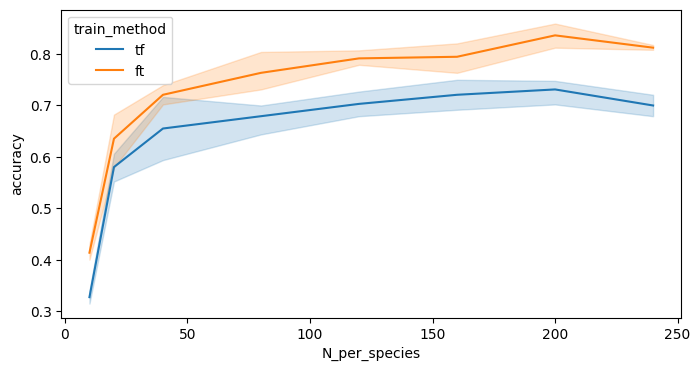

In [11]:
import seaborn as sb
fig, ax = plt.subplots(1, figsize=(8,4))
sb.lineplot(performance_df, x="N_per_species", y="accuracy", hue="train_method", ax=ax)